# Shopify Data Science Internship Challenge

Author: Seth Mackie
Date: 2022-05-11

## Step 1: Define the Problem

After being provided a dataset, we are given the following prompt:

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
2. What metric would you report for this dataset?
3. What is its value?
    - Please note that I am interpreting this question 2 ways:
    1. What is the numerical value of this metric?
    2. Why is this metric valuable?


## Step 2: Import Libraries
Importing standard data science libraries. I didn't end up using numpy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


After downloading the csv file, I load it into a Pandas dataframe.

In [2]:
df_raw = pd.read_csv('data/spotify_data.csv', parse_dates=True)

I make a copy of the dataframe that I can freely play with.

In [3]:
df = df_raw.copy(deep=True)

A first look at some summary statistics of the dataset. 

I notice that mean value of order_amount is quite high at $3145.13. I also notice that the standard deviation of order_amount is incredibly high at $41282.54. The first, second, and third quartiles all seem reasonable, as does the minimum value, but the maximum value is a bit extreme at $704,000. That's a lot of sneakers. We'll definitely need to look closer at that.

I also notice that the standard deviation and maximum values for the total_items column are suspisiously high. We'll need to look closer at that.

Lastly, I notice that the create_at column doesn't have numerical summary statistics. I'm assuming it was loaded as a string (object). That's easy to check.

In [4]:
df.describe(include='all')

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000,5000
unique,NaN,NaN,NaN,NaN,NaN,3,4991
top,NaN,NaN,NaN,NaN,NaN,credit_card,2017-03-28 4:00:00
freq,NaN,NaN,NaN,NaN,NaN,1735,3
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720,NaN,NaN
std,1443.520003,29.006118,87.798982,41282.539349,116.32032,NaN,NaN
min,1.000000,1.000000,607.000000,90.000000,1.00000,NaN,NaN
25%,1250.750000,24.000000,775.000000,163.000000,1.00000,NaN,NaN
50%,2500.500000,50.000000,849.000000,284.000000,2.00000,NaN,NaN
75%,3750.250000,75.000000,925.000000,390.000000,3.00000,NaN,NaN


Let's check data types of each column. We're primarly looking at the created_at column to see if it's a datetime or an object (string) like I suspected.

In [5]:
df.dtypes

order_id           int64
shop_id            int64
user_id            int64
order_amount       int64
total_items        int64
payment_method    object
created_at        object
dtype: object

Yep! It's an object datatype. Let's fix that.

In [6]:
df['created_at'] = pd.to_datetime(df['created_at'])
df.dtypes

order_id                   int64
shop_id                    int64
user_id                    int64
order_amount               int64
total_items                int64
payment_method            object
created_at        datetime64[ns]
dtype: object

Much better. Now we can do some analysis.

## Step 3: Exploratory Data Analysis (Data Mining)

One column that I feel could be helpful is a "price_per_item" column. Let's add it. Since we know from our instructions that each shop only has one item, we can assume that the price per item is the order_amount divided by the total_items.

In [7]:
df["price_per_item"] = df.order_amount / df.total_items
df

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
0,1,53,746,224,2,cash,2017-03-13 12:36:56,112.0
1,2,92,925,90,1,cash,2017-03-03 17:38:52,90.0
2,3,44,861,144,1,cash,2017-03-14 04:23:56,144.0
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,156.0
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11,156.0
...,...,...,...,...,...,...,...,...
4995,4996,73,993,330,2,debit,2017-03-30 13:47:17,165.0
4996,4997,48,789,234,2,cash,2017-03-16 20:36:16,117.0
4997,4998,56,867,351,3,cash,2017-03-19 05:42:42,117.0
4998,4999,60,825,354,2,credit_card,2017-03-16 14:51:18,177.0


Let's get another look at the summary statistics after adding this column and changing the created_at column to a datetime.

In [8]:
df.describe(include='all', datetime_is_numeric=True)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000,5000,5000.000000
unique,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,credit_card,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,1735,NaN,NaN
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720,NaN,2017-03-15 22:20:37.076199936,387.742800
min,1.000000,1.000000,607.000000,90.000000,1.00000,NaN,2017-03-01 00:08:09,90.000000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000,NaN,2017-03-08 07:08:03.750000128,133.000000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000,NaN,2017-03-16 00:21:20.500000,153.000000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000,NaN,2017-03-23 10:39:58.249999872,169.000000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000,NaN,2017-03-30 23:55:35,25725.000000


I'm noticing that the min and max values for created_at are in line with what I'm expecting. Early morning March 1st to late evening March 31st.

As for the newly created price_per_item column, I'm noticing that the mean is much higher than the median, which is concerning. Also, I consider $387.74 to be a bit for a pair of shoes, especially as the average price. The median price of $153 seems much more reasonable. The max value of $25,725 seems extreme to me. Assuming this data isn't erronious, someone paid for for their shoes than I did for my car. Lastly, the standard deviation for the price_per_item column is much higher than I would expect. We'll definitly be looking for outliers. 

Let's check the mode real quick for the order_amount, total_items, and price_per_item columns.

In [9]:
df.order_amount.mode()

0    153
Name: order_amount, dtype: int64

In [10]:
df.order_amount.value_counts().sort_values(ascending=False)

153     87
306     85
354     82
160     75
156     75
        ..
816      1
740      1
735      1
1064     1
650      1
Name: order_amount, Length: 258, dtype: int64

In [11]:
df.total_items.mode()

0    2
Name: total_items, dtype: int64

In [12]:
df.total_items.value_counts().sort_values(ascending=False)

2       1832
1       1830
3        941
4        293
5         77
2000      17
6          9
8          1
Name: total_items, dtype: int64

In [13]:
df.price_per_item.mode()

0    153.0
Name: price_per_item, dtype: float64

It makes sense that the most frequent order amounts are $153.00 and $306.00 when the most frequent shoe price is $153.00 and the most frequent total items are 1 and 2.

Time to look for some outliers. Let's start by taking a look at the highest values for the order_amount column. I want to see if it's just a couple really large values, or a lot of really large values.

In [14]:
df.sort_values(by='order_amount', ascending=False)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
2153,2154,42,607,704000,2000,credit_card,2017-03-12 04:00:00,352.0
3332,3333,42,607,704000,2000,credit_card,2017-03-24 04:00:00,352.0
520,521,42,607,704000,2000,credit_card,2017-03-02 04:00:00,352.0
1602,1603,42,607,704000,2000,credit_card,2017-03-17 04:00:00,352.0
60,61,42,607,704000,2000,credit_card,2017-03-04 04:00:00,352.0
...,...,...,...,...,...,...,...,...
3871,3872,92,818,90,1,debit,2017-03-18 09:10:08,90.0
2503,2504,92,935,90,1,credit_card,2017-03-28 02:30:26,90.0
4414,4415,92,927,90,1,credit_card,2017-03-17 09:57:01,90.0
3363,3364,92,730,90,1,credit_card,2017-03-11 23:20:31,90.0


Looks like there are more than a few large values. Let's look at a histogram to get a sense of the distribution.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='order_amount'>

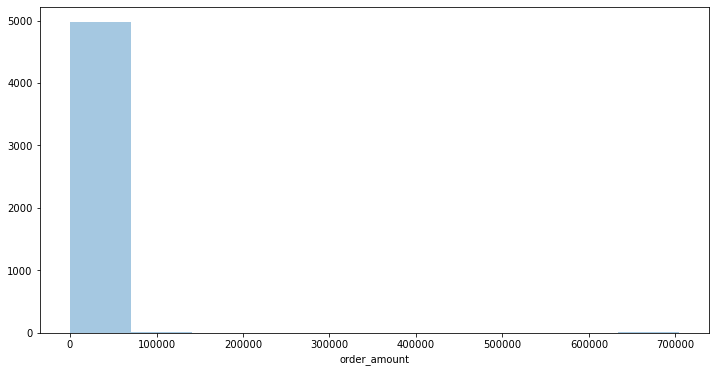

In [15]:
plt.figure(figsize=(12, 6))
sns.distplot(df.order_amount, bins=10, kde=False)

<AxesSubplot:xlabel='order_amount', ylabel='Density'>

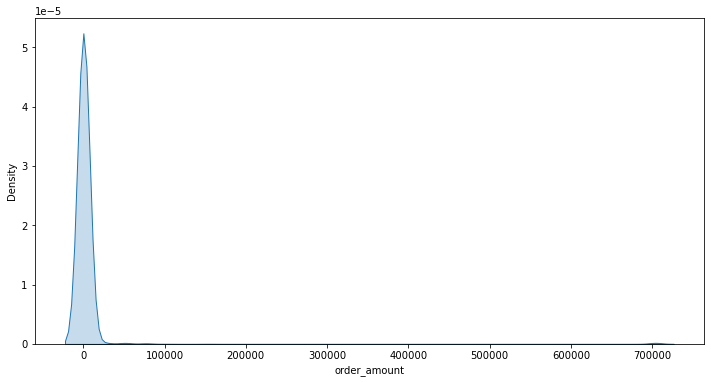

In [16]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df.order_amount, shade=True)

That is one skewed distribution... 
Let's see if we can identity some outliers.

In [17]:
df.order_amount.value_counts().sort_index(ascending=False)

704000    17
154350     1
102900     1
77175      9
51450     16
          ..
112       48
111       16
101       15
94        25
90        18
Name: order_amount, Length: 258, dtype: int64

Looks like there a few orders that are really big. Let's see if there are some categories we can associate with these massive orders.

In [18]:
df.groupby('shop_id').order_amount.mean().sort_values(ascending=False)

shop_id
42     235101.490196
78      49213.043478
50        403.545455
90        403.224490
38        390.857143
           ...      
53        214.117647
100       213.675000
32        189.976190
2         174.327273
92        162.857143
Name: order_amount, Length: 100, dtype: float64

This is a big insight! Looks like shops 42 and 78 have WAY higher average order amounts than the rest of the shops. Let's see what happens if we separate these two shops out.

In [19]:
df_shop_42 = df.loc[df.shop_id == 42]
df_shop_78 = df.loc[df.shop_id == 78]

df_other_shops = df.loc[~df.shop_id.isin([42, 78])]

How many rows were in the original dataframe? 

How many rows are left in the new df_other_shops dataframe?

In [20]:
print(f'Rows in original df: {len(df)}')
print(f'Rows in df_other_shops: {len(df_other_shops)}')

rows_removed = len(df) - len(df_other_shops)
print(f'Rows removed: {rows_removed}')

percent_removed = rows_removed / len(df) * 100
print(f'Percent removed: {percent_removed:.2f}%')

Rows in original df: 5000
Rows in df_other_shops: 4903
Rows removed: 97
Percent removed: 1.94%


Let's summarize the new dataframe.

In [21]:
df_other_shops.describe(include='all', datetime_is_numeric=True)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
count,4903.000000,4903.000000,4903.000000,4903.000000,4903.000000,4903,4903,4903.000000
unique,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,credit_card,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,1698,NaN,NaN
mean,2499.584540,49.900877,849.858862,300.155823,1.995717,NaN,2017-03-15 22:10:55.943299840,150.400163
min,1.000000,1.000000,700.000000,90.000000,1.000000,NaN,2017-03-01 00:08:09,90.000000
25%,1246.500000,24.000000,776.000000,163.000000,1.000000,NaN,2017-03-08 06:23:40,132.000000
50%,2499.000000,50.000000,850.000000,284.000000,2.000000,NaN,2017-03-15 23:46:37,153.000000
75%,3750.500000,74.000000,925.000000,386.500000,3.000000,NaN,2017-03-23 10:28:42,166.000000
max,5000.000000,100.000000,999.000000,1086.000000,8.000000,NaN,2017-03-30 23:55:35,201.000000


This looks so much better! All summary measures for order amount, total_items, and price_per_item seem totally reasonable. Let's take a look at the distribution of this new dataframe with shops 42 and 78 removed.

<AxesSubplot:title={'center':'Frequency Distribution of Order Amounts (shops 42 and 78 omitted)'}, xlabel='order_amount', ylabel='Count'>

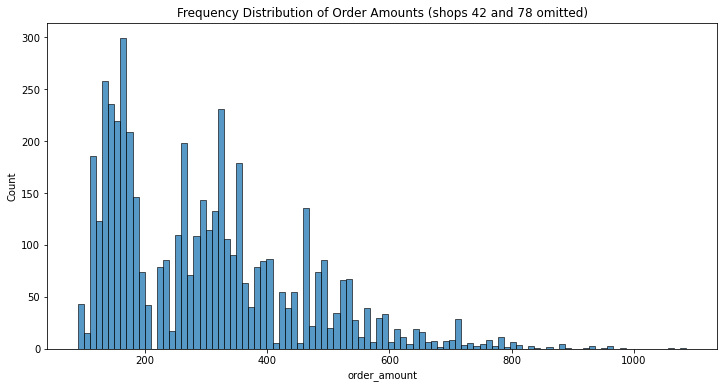

In [22]:
plt.figure(figsize=(12, 6))
plt.title("Frequency Distribution of Order Amounts (shops 42 and 78 omitted)")
sns.histplot(df_other_shops.order_amount, bins=100, kde=False)

While the dataset is still skewed to the right, this looks much more reasonable. Let's take a look at the distributions for total_items and price_per_item.

<AxesSubplot:title={'center':'Frequency Distribution of Total Items (shops 42 and 78 omitted)'}, xlabel='total_items', ylabel='Count'>

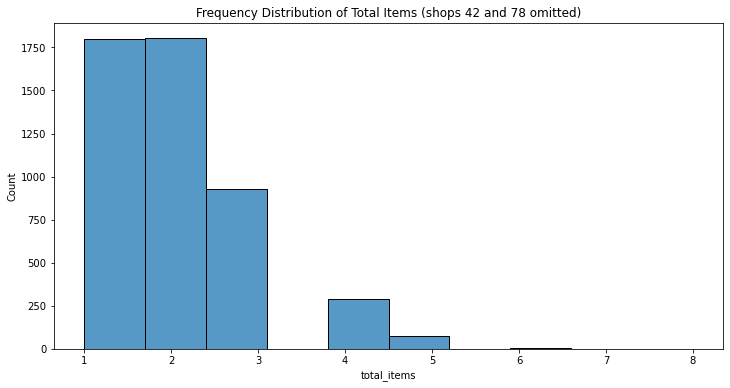

In [23]:
plt.figure(figsize=(12, 6))
plt.title("Frequency Distribution of Total Items (shops 42 and 78 omitted)")
sns.histplot(df_other_shops.total_items, bins=10, kde=False)

<AxesSubplot:title={'center':'Frequency Distribution of Price Per Item (shops 42 and 78 omitted)'}, xlabel='price_per_item', ylabel='Count'>

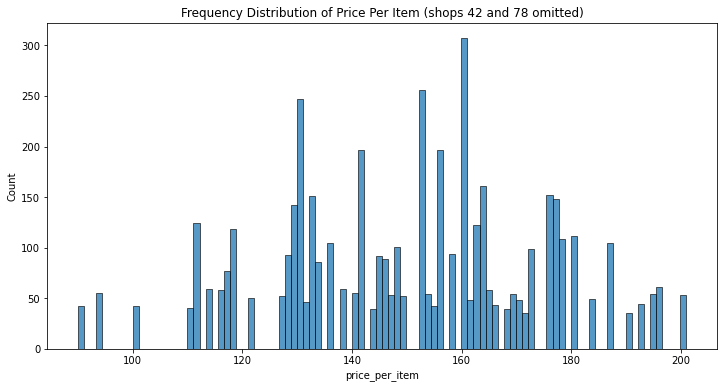

In [24]:
plt.figure(figsize=(12, 6))
plt.title("Frequency Distribution of Price Per Item (shops 42 and 78 omitted)")
sns.histplot(df_other_shops.price_per_item, bins=100, kde=False)

I condiser both of the above distributions to be sensible. Let's take a look at how Order Amount looks over time.

<AxesSubplot:xlabel='created_at', ylabel='order_amount'>

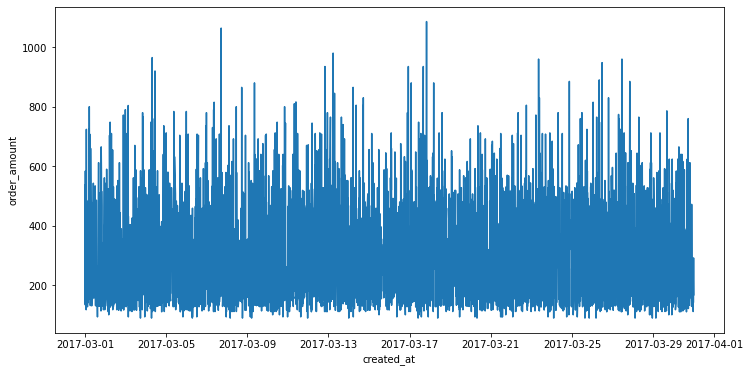

In [25]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='created_at', y='order_amount', data=df_other_shops)

That's kind of a mess. Let's try just looking at one shop.

<AxesSubplot:xlabel='created_at', ylabel='order_amount'>

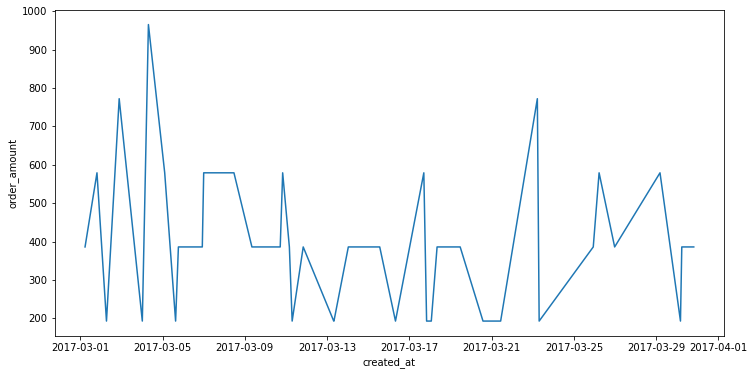

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='created_at', y='order_amount', data=df_other_shops.loc[df_other_shops.shop_id == 50])

This doesn't seem particularly insightful. Let's try a scatter plot.

<AxesSubplot:xlabel='created_at', ylabel='order_amount'>

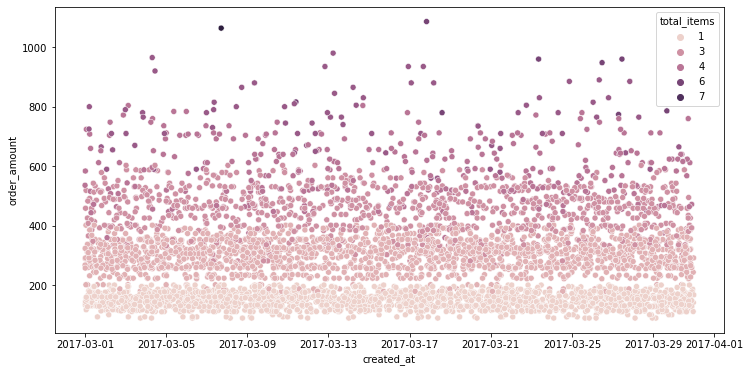

In [27]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='created_at', y='order_amount', hue='total_items', data=df_other_shops)

This appears to be a fairly uniform distribution. I will say that there does appear to be some kind of gap in the data above $200. I wonder why that's there? I'm not going to dig into that now because it's not the purpose of this challenge, but it does seem interesting.

Before returning to our outliers, let's look at the mode of this dataset with the outliers removed. I don't expect it to change much, if at all. But let's double check.

In [28]:
df_other_shops.order_amount.value_counts().sort_values(ascending=False)

153     87
306     85
354     82
160     75
156     75
        ..
740      1
735      1
725      1
1086     1
650      1
Name: order_amount, Length: 249, dtype: int64

In [29]:
df_other_shops.total_items.value_counts().sort_values(ascending=False)

2    1803
1    1796
3     929
4     290
5      76
6       8
8       1
Name: total_items, dtype: int64

In [30]:
df_other_shops.price_per_item.value_counts().sort_values(ascending=False)

153.0    256
160.0    206
156.0    197
142.0    197
164.0    161
176.0    152
133.0    151
130.0    150
177.0    148
129.0    142
112.0    124
163.0    122
118.0    118
181.0    112
178.0    109
187.0    105
136.0    105
161.0    101
148.0    101
173.0     99
131.0     97
158.0     94
128.0     93
145.0     92
146.0     89
134.0     86
117.0     77
196.0     61
114.0     59
138.0     59
116.0     58
165.0     58
140.0     55
94.0      55
154.0     54
169.0     54
195.0     54
201.0     53
147.0     53
127.0     52
149.0     52
122.0     50
184.0     49
162.0     48
171.0     48
132.0     46
193.0     44
166.0     43
90.0      42
155.0     42
101.0     42
111.0     40
144.0     39
168.0     39
172.0     35
190.0     35
Name: price_per_item, dtype: int64

Everything checks out!

Let's go back to our outliers, and try to see if we can understand what's going on.

In [31]:
df_shop_42.describe(include='all', datetime_is_numeric=True)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
count,51.000000,51.0,51.000000,51.000000,51.000000,51,51,51.0
unique,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,credit_card,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,27,NaN,NaN
mean,2441.921569,42.0,758.588235,235101.490196,667.901961,NaN,2017-03-15 06:46:01.333333504,352.0
min,16.000000,42.0,607.000000,352.000000,1.000000,NaN,2017-03-01 12:19:49,352.0
25%,1366.500000,42.0,607.000000,352.000000,1.000000,NaN,2017-03-08 09:59:03.500000,352.0
50%,2154.000000,42.0,770.000000,704.000000,2.000000,NaN,2017-03-13 23:43:45,352.0
75%,3801.000000,42.0,863.500000,704000.000000,2000.000000,NaN,2017-03-24 04:00:00,352.0
max,4883.000000,42.0,975.000000,704000.000000,2000.000000,NaN,2017-03-28 04:00:00,352.0


Shop 42 had 51 orders with an average order_amount of $235,101,49 per order. That seems extreme. Let's see if we can identify a pattern.

<AxesSubplot:xlabel='user_id', ylabel='order_amount'>

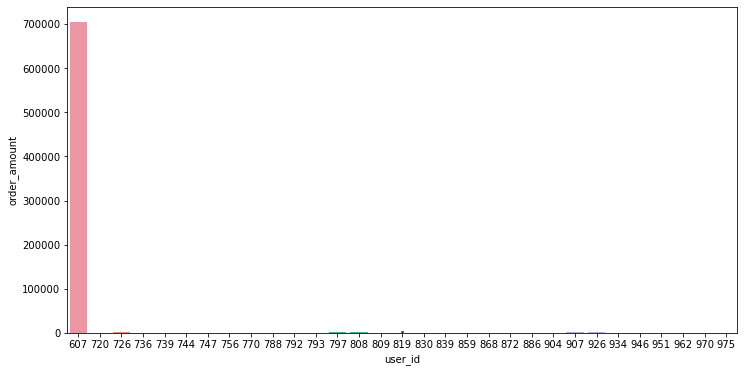

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(x='user_id', y='order_amount', data=df_shop_42)

Looks like there is something going on with user 607. Let's drill into that.

In [33]:
df_shop_42.loc[df_shop_42.user_id == 607].order_amount.value_counts()

704000    17
Name: order_amount, dtype: int64

In [34]:
df_shop_42.loc[df_shop_42.user_id == 607]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
15,16,42,607,704000,2000,credit_card,2017-03-07 04:00:00,352.0
60,61,42,607,704000,2000,credit_card,2017-03-04 04:00:00,352.0
520,521,42,607,704000,2000,credit_card,2017-03-02 04:00:00,352.0
1104,1105,42,607,704000,2000,credit_card,2017-03-24 04:00:00,352.0
1362,1363,42,607,704000,2000,credit_card,2017-03-15 04:00:00,352.0
1436,1437,42,607,704000,2000,credit_card,2017-03-11 04:00:00,352.0
1562,1563,42,607,704000,2000,credit_card,2017-03-19 04:00:00,352.0
1602,1603,42,607,704000,2000,credit_card,2017-03-17 04:00:00,352.0
2153,2154,42,607,704000,2000,credit_card,2017-03-12 04:00:00,352.0
2297,2298,42,607,704000,2000,credit_card,2017-03-07 04:00:00,352.0


Looks like the only business between shop 42 and user 607 are these 17 orders, each for exactly $704,000.00. All of these were for 2,000 pairs of shoes.

<AxesSubplot:xlabel='created_at', ylabel='Count'>

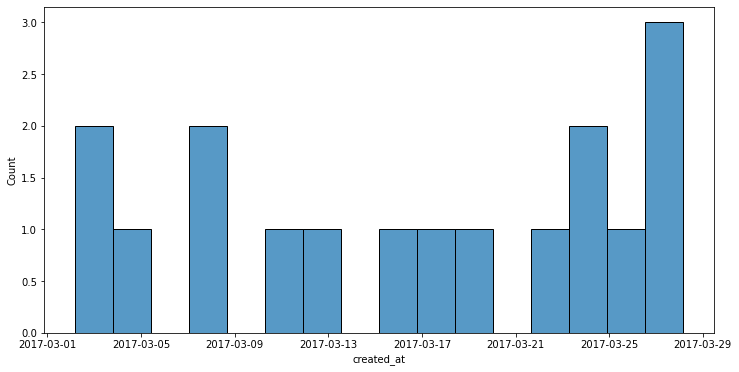

In [35]:
plt.figure(figsize=(12, 6))
sns.histplot(df_shop_42.loc[df_shop_42.user_id == 607].created_at, bins=16, kde=False)

Looks like these orders were placed throughout the month. 

This is clearly a huge outlier compared to the rest of the data and should be considered seperatly. This data was certainly skewing the averages for the whole dataset.

Next, let's take a look at our other outlier, shop 78.

In [36]:
df_shop_78.describe(include='all', datetime_is_numeric=True)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
count,46.000000,46.0,46.000000,46.000000,46.000000,46,46,46.0
unique,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,debit,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN
mean,2663.021739,78.0,867.739130,49213.043478,1.913043,NaN,2017-03-17 08:49:09.195652352,25725.0
min,161.000000,78.0,707.000000,25725.000000,1.000000,NaN,2017-03-01 03:02:10,25725.0
25%,1428.250000,78.0,812.500000,25725.000000,1.000000,NaN,2017-03-13 08:19:02.249999872,25725.0
50%,2796.500000,78.0,866.500000,51450.000000,2.000000,NaN,2017-03-17 17:24:00,25725.0
75%,3720.250000,78.0,935.750000,51450.000000,2.000000,NaN,2017-03-22 18:27:52,25725.0
max,4919.000000,78.0,997.000000,154350.000000,6.000000,NaN,2017-03-30 12:23:43,25725.0


Shop 78 had 46 orders in March. The first thing that jumps out to me is the price_per_item at $25,725. That's a very expensive pair of shoes. I want to see what shoe prices look like in the dataset as a whole.

In [37]:
df.price_per_item.value_counts().sort_index(ascending=False)

25725.0     46
352.0       51
201.0       53
196.0       61
195.0       54
193.0       44
190.0       35
187.0      105
184.0       49
181.0      112
178.0      109
177.0      148
176.0      152
173.0       99
172.0       35
171.0       48
169.0       54
168.0       39
166.0       43
165.0       58
164.0      161
163.0      122
162.0       48
161.0      101
160.0      206
158.0       94
156.0      197
155.0       42
154.0       54
153.0      256
149.0       52
148.0      101
147.0       53
146.0       89
145.0       92
144.0       39
142.0      197
140.0       55
138.0       59
136.0      105
134.0       86
133.0      151
132.0       46
131.0       97
130.0      150
129.0      142
128.0       93
127.0       52
122.0       50
118.0      118
117.0       77
116.0       58
114.0       59
112.0      124
111.0       40
101.0       42
94.0        55
90.0        42
Name: price_per_item, dtype: int64

As I suspected, $25,725 is a hugh outlier. This explains why shop 78 has such a high average order_amount.

Now that we have a better understanding of the outliers, and what our data looks like with the outliers removed, let's move on to answer the questions.

## Step 4: Answering the Questions

#### Question 1: Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 


This one is pretty clear. The average order value (AOV) is a misleading measure of central tendency because it is based on the mean of the order_amount column, which contains some extreme outliers. By removing the outliers, we can see that the average order value is much closer to the median, and much more sensible overall. 

- mean order_amount prior to removing outliers: $3,145.13
- median order_amount prior to removing outliers: $284.00
- mode order_amount prior to removing outliers: $153.00
- standard deviation prior to removing outliers: $41,282.54


* mean order_amount after removing outliers: $300.16
* median order_amount after removing outliers: $284.00
* mode order_amount after removing outliers: $153.00
* standard deviation after removing outliers: $155.94

In [38]:
df_other_shops.describe(include='all', datetime_is_numeric=True)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
count,4903.000000,4903.000000,4903.000000,4903.000000,4903.000000,4903,4903,4903.000000
unique,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,credit_card,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,1698,NaN,NaN
mean,2499.584540,49.900877,849.858862,300.155823,1.995717,NaN,2017-03-15 22:10:55.943299840,150.400163
min,1.000000,1.000000,700.000000,90.000000,1.000000,NaN,2017-03-01 00:08:09,90.000000
25%,1246.500000,24.000000,776.000000,163.000000,1.000000,NaN,2017-03-08 06:23:40,132.000000
50%,2499.000000,50.000000,850.000000,284.000000,2.000000,NaN,2017-03-15 23:46:37,153.000000
75%,3750.500000,74.000000,925.000000,386.500000,3.000000,NaN,2017-03-23 10:28:42,166.000000
max,5000.000000,100.000000,999.000000,1086.000000,8.000000,NaN,2017-03-30 23:55:35,201.000000


#### Question 2: What metric would you report for this dataset?
If an immediate metric was necessary, I would provide the median and mode metrics for order_amount. If I had an hour or so to analyze the data to understand its outliers, I would also provide the mean and standard deviation of order_amount after removing outliers.


#### Question 3: What is its value?
##### Interpretation 1: What is the numerical value of this metric?
1. The median order_amount is $284.00.
2. The mode of order_amount is $153.00 and the second most frequent order_amount is $306.00
3. The mean order_amount after removing outliers (records with shop_id 42 or 78) is $300.16.
4. The standard deviation of order_amount after removing outliers (records with shop_id 42 or 78) is $155.94.

##### Interpretation 2: Why is this metric valuable?
- These measures of central tendency (mean, median, and mode) give us an idea of a central point around which the rest of our data are distributed.
- Measures of central variability, such as standard deviation, describe how spread out our data is from its mean. 
- By combining these measures of central tendency and central variability, we can develop a pretty good intuition of where our data is distributed and how spread out it is.


## Step 5: Due Diligence
There are, of course, other ways to identify outliers. And while I'm satisfied with the quality of my analysis thus far, let's try a different method for the sake of due diligence.

The interquartile range (IQR) is the distance between the first and third quartiles. It is a measure of the spread of the data. And we can use it to identify outliers.

In [39]:
quartile_1 = df.order_amount.quantile(0.25)
quartile_3 = df.order_amount.quantile(0.75)

print(f'quartile_1: {quartile_1}')
print(f'quartile_3: {quartile_3}')

iqr = quartile_3 - quartile_1
print(f'iqr: {iqr}')

quartile_1: 163.0
quartile_3: 390.0
iqr: 227.0


We use these values to determine upper and lower bounds for acceptable values. All values outside these bounds we will condsider outliers.

- Lower bound: quartile_1 - (1.5 * IQR)
- Upper bound: quartile_3 + (1.5 * IQR)

In [40]:
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)

print(f'lower_bound: {lower_bound}')
print(f'upper_bound: {upper_bound}')


lower_bound: -177.5
upper_bound: 730.5


Now we can use these bounds to identify outliers. We will add a new Boolean column to our dataframe called is_outlier. This field will be 1 if the value is an outlier and 0 if it is not.

In [41]:
df["is_outlier"] = df.order_amount.apply(lambda x: 1 if x < lower_bound or x > upper_bound else 0)
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item,is_outlier
0,1,53,746,224,2,cash,2017-03-13 12:36:56,112.0,0
1,2,92,925,90,1,cash,2017-03-03 17:38:52,90.0,0
2,3,44,861,144,1,cash,2017-03-14 04:23:56,144.0,0
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,156.0,0
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11,156.0,0


Now we can create a new dataframe that only contains values that are NOT outliers.

In [42]:
df_outliers_removed = df.loc[df.is_outlier == 0]
df_outliers_removed.describe(include='all', datetime_is_numeric=True)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item,is_outlier
count,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859,4859,4859.000000,4859.0
unique,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,credit_card,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,1680,NaN,NaN,NaN
mean,2497.395966,49.852645,849.905742,293.715374,1.950196,NaN,2017-03-15 22:19:11.362625792,151.265281,0.0
min,1.000000,1.000000,700.000000,90.000000,1.000000,NaN,2017-03-01 00:08:09,90.000000,0.0
25%,1244.500000,24.000000,776.000000,162.000000,1.000000,NaN,2017-03-08 06:39:28,132.000000,0.0
50%,2498.000000,50.000000,850.000000,280.000000,2.000000,NaN,2017-03-16 00:16:50,153.000000,0.0
75%,3749.500000,74.000000,925.000000,380.000000,3.000000,NaN,2017-03-23 10:40:17.500000,166.000000,0.0
max,5000.000000,100.000000,999.000000,730.000000,5.000000,NaN,2017-03-30 23:55:35,352.000000,0.0


We can see that all summary measures for order amount, total_items, and price_per_item are reasonable. This would have been another way to handle outliers in our dataset.

How many rows were removed?

In [43]:
print(f'Rows in original df: {len(df)}')
print(f'Rows in df_outliers_removed: {len(df_outliers_removed)}')

rows_removed = len(df) - len(df_outliers_removed)
print(f'Rows removed: {rows_removed}')

percent_removed = rows_removed / len(df) * 100
print(f'Percent removed: {percent_removed:.2f}%')

Rows in original df: 5000
Rows in df_outliers_removed: 4859
Rows removed: 141
Percent removed: 2.82%


## Step 6: Conclusion

This was a fun challenge! I feel like we were able to quickly identify some outliers and remove them from our data. After that, I think the data started to really make sense, and could possibly be used to help us understand shoe sells on Shopify stores.

From here, I still have a few questions that could be worth investigating.
1. What is up with shop 42 and all the orders to user 607? Why did they place 17 orders for 2,000 pairs of shoes in a single month? 
2. Does shop 78 really sell shoes at $25,725? Do they have rockets built in? 
3. Why is there a that strange gap at about $200 in the scatterplot above? why are there no orders at $200? It might not be important, it just seems weird.
4. How does this month's data compare to other months? Can we use historical monthly sales data to predict future sales?